# Sentiment Analysis Comparison

In this notebook, we'll compare all three approaches to sentiment analysis and compare the accuracy, confusion matrices and let you explore each one with your input.

First, we need to use the same dataset for the input, to make it a fair fight :)

In [1]:
## all imports
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from keras.datasets import imdb
from keras.preprocessing import sequence

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## Preparing the data

We'll get 25000 labeled imdb reviews. 22500 for training and 2500 for testing.

We will use the Keras dataset, because it has a word index function to retrieve a word from an index.

> Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

>As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

> [Keras documentation](https://keras.io/datasets/)

In [2]:
# IMDB Dataset loading from keras
# We'll only get the first 10000 most frequent words
N_MOST_FREQUENT_WORDS = 10000

train, test = imdb.load_data(path='imdb.pkl',  nb_words = N_MOST_FREQUENT_WORDS+1, index_from=0, oov_char=0)

trainX, trainY = train # train is a tuple, here we divide this tuple
testX, testY = test

# There is a bug in the Keras's implementation, always train == test, so we need to split it by hand
trainX = trainX[:22500]
trainY = trainY[:22500]
testX = testX[22500:]
testY = testY[22500:]

In [3]:
word_to_index = imdb.get_word_index()
word_to_index = {k: v for k, v in word_to_index.items() if v <= N_MOST_FREQUENT_WORDS}
index_to_word = {v: k for k, v in word_to_index.items()}

print(sorted(word_to_index.items(), key=lambda x: x[1])[:5])
print(sorted(word_to_index.items(), key=lambda x: x[1], reverse=True)[:5])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5)]
[('approved', 10000), ('beaver', 9999), ('shenanigans', 9998), ('retains', 9997), ('edged', 9996)]


In [4]:
def phrase_to_index_list(phrase):
    result = []
    phrase = phrase.lower()
    for word in phrase.split():
        result.append(word_to_index.get(word, 0))
    return result

phrase_to_index_list("I hate this movie unknownword")

[10, 781, 11, 17, 0]

In [5]:
def index_list_to_phrase(index_list):
    result = []
    for word_index in index_list:
        result.append(index_to_word.get(word_index, "UNKNOW"))
    return result

print("the ACTUAL review (lol) http://www.imdb.com/title/tt0091339/reviews-22 \n")
print(" ".join(index_list_to_phrase(trainX[1])), "\n")
print("Label: ", trainY[1])

the ACTUAL review (lol) http://www.imdb.com/title/tt0091339/reviews-22 

the big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal UNKNOW the hair is big lots of boobs UNKNOW men wear those cut UNKNOW shirts that show off their UNKNOW sickening that men actually wore them and the music is just UNKNOW trash that plays over and over again in almost every scene there is trashy music boobs and UNKNOW taking away bodies and the gym still doesn't close for UNKNOW all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a

### Text to fixed vector

Trask and Mat used fixed vector. We will use 10000 words + 1 (for the words that are not in the dictionary) for the input vector.

In [6]:
def index_sequence_to_vector(index_sequence_list):
    result = np.zeros(N_MOST_FREQUENT_WORDS + 1)
    for word_index in index_sequence_list:
        result[word_index] = result[word_index] + 1
    return result

In [7]:
print(index_sequence_to_vector(trainX[1])[:10])
print(sorted(word_to_index.items(), key=lambda x: x[1])[:9])

[  7.  16.  10.   3.   2.   3.  10.   0.   2.   0.]
[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9)]


The review trainX[1] has 7 unknown words in the dictionary, 16 "the", 10 "and"... You can check it yourself using the review above.

This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
[Credits: sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [8]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure()
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

![''](https://media.licdn.com/mpr/mpr/shrinknp_400_400/AAEAAQAAAAAAAAQuAAAAJDY5ODU4NDA4LTY2NjAtNDY0MS1iNDBlLWU4OGVlYmUxOGI0Yw.jpg)

## First contender: Siraj Raval

In [9]:
# Data preprocessing
_trainX = pad_sequences(trainX, maxlen=100, value=0.)
_testX = pad_sequences(testX, maxlen=100, value=0.)
# Converting labels to binary vectors
_trainY = to_categorical(trainY, nb_classes=2)
_testY = to_categorical(testY, nb_classes=2)

def buildSirajModel():

    # Network building
    net = tflearn.input_data([None, 100])
    net = tflearn.embedding(net, input_dim=N_MOST_FREQUENT_WORDS+1, output_dim=128) # +1 is for the 0 index -> the unknow words in the dictionary
    net = tflearn.lstm(net, 128, dropout=0.8, dynamic=True)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)
    return model

sirajModel = buildSirajModel()
sirajModel.fit(_trainX, _trainY, validation_set=(_testX, _testY), show_metric=True, n_epoch=8) 
# 10 epochs (default) was overfitting | Adam | epoch: 010 | loss: 0.04873 - acc: 0.9838 | val_loss: 1.03306 - val_acc: 0.7764 -- iter: 22500/22500

Training Step: 2815  | total loss: 0.08107 | time: 50.294s
| Adam | epoch: 008 | loss: 0.08107 - acc: 0.9782 -- iter: 22464/22500
Training Step: 2816  | total loss: 0.08927 | time: 51.907s
| Adam | epoch: 008 | loss: 0.08927 - acc: 0.9773 | val_loss: 0.75877 - val_acc: 0.7928 -- iter: 22500/22500
--


Siraj Test accuracy:  [0.79279999999999995]


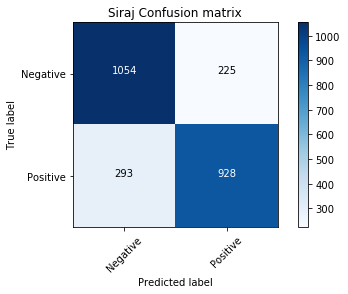

In [10]:
y_true_siraj = testY
# (first output < second output) -> negative label else positive label
y_pred_siraj = np.apply_along_axis(lambda x: x[0] < x[1], 1, sirajModel.predict(_testX)) 

score = sirajModel.evaluate(_testX, _testY)
print('Siraj Test accuracy: ' , score)

plot_confusion_matrix(confusion_matrix(y_true_siraj, y_pred_siraj), classes=['Negative', 'Positive'], title='Siraj Confusion matrix')

## Second contender: Mat Leonard

In [11]:
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    net = tflearn.input_data([None, N_MOST_FREQUENT_WORDS + 1])

    # Hidden layer(s)
    net = tflearn.fully_connected(net, 200, activation='ReLU')
    net = tflearn.fully_connected(net, 25, activation='ReLU')

    # Output layer
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='sgd', 
                             learning_rate=0.1, 
                             loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    return model

In [12]:
matModel = build_model()

_testY = to_categorical(testY, nb_classes=2)
_trainY = to_categorical(trainY, nb_classes=2)

# convert index list to fixed bag of words by frequence
_trainX = []
for review in trainX:
    _trainX.append(np.asarray(index_sequence_to_vector(review)))

_testX = []
for review in testX:
    _testX.append(np.asarray(index_sequence_to_vector(review)))
    
# Training
matModel.fit(_trainX, _trainY, validation_set=0.1, show_metric=True, batch_size=128, n_epoch=30)


Training Step: 4769  | total loss: 0.40239 | time: 2.684s
| SGD | epoch: 030 | loss: 0.40239 - acc: 0.8574 -- iter: 20224/20250
Training Step: 4770  | total loss: 0.38860 | time: 3.706s
| SGD | epoch: 030 | loss: 0.38860 - acc: 0.8655 | val_loss: 0.35210 - val_acc: 0.8480 -- iter: 20250/20250
--


Mat Test accuracy:  [0.85080000076293949]


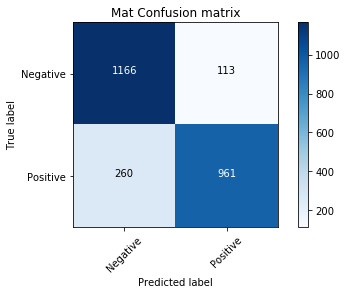

In [13]:
y_true_mat = testY
# (first output < second output) -> negative label else positive label
y_pred_mat = np.apply_along_axis(lambda x: x[0] < x[1], 1, matModel.predict(_testX)) 

score = matModel.evaluate(np.array(_testX), _testY)
print('Mat Test accuracy: ' , score)

plot_confusion_matrix(confusion_matrix(y_true_mat, y_pred_mat), classes=['Negative', 'Positive'], title='Mat Confusion matrix')

## Third contender: Andrew Trask

In [14]:
import time
import sys
import numpy as np
from collections import Counter

# Let's tweak our network from before to model these phenomena
class SentimentNetwork:
    def __init__(self, reviews,labels,min_count = 10,polarity_cutoff = 0.1,hidden_nodes = 10, learning_rate = 0.1):
       
        np.random.seed(1)
    
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)
        
        
    def pre_process_data(self,reviews,labels, polarity_cutoff,min_count):
        
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
         
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        self.learning_rate = learning_rate
        
        self.layer_0 = np.zeros((1,input_nodes))
        self.layer_1 = np.zeros((1,hidden_nodes))
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    def update_input_layer(self,review):

        # clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        for word in review.split(" "):
            self.layer_0[0][self.word2index[word]] = 1

    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def train(self, training_reviews_raw, training_labels):
        
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
        
        assert(len(training_reviews) == len(training_labels))
        
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            # Input Layer

            # Hidden layer
#             layer_1 = self.layer_0.dot(self.weights_0_1)
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
            
            # Output layer
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))

            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            if(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            reviews_per_second = i / float(time.time() - start + 1)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
        
    
    def test(self, testing_reviews, testing_labels):
        
        correct = 0
        
        result = []
        
        start = time.time()
        
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            result.append(self.get_target_for_label(pred))
            if(pred == testing_labels[i]):
                correct += 1
            
            reviews_per_second = i / float(time.time() - start + 1)
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                            + "% #Correct:" + str(correct) + " #Tested:" + str(i+1) + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
        return result
        
    def run(self, review, detailed=False):
        
        # Input Layer


        # Hidden layer
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        if detailed:
            return layer_2[0]
        else:
            if(layer_2[0] >= 0.5):
                return "POSITIVE"
            else:
                return "NEGATIVE"

In [15]:
# adapting the data
trainReviews = []
for review in trainX:
    trainReviews.append(" ".join(index_list_to_phrase(review)))
testReviews = []
for review in testX:
    testReviews.append(" ".join(index_list_to_phrase(review)))
    
testLabels = []
for label in testY:
    testLabels.append('POSITIVE' if label == 1 else 'NEGATIVE')
trainLabels = []
for label in trainY:
    trainLabels.append('POSITIVE' if label == 1 else 'NEGATIVE')

In [16]:
traskModel = SentimentNetwork(trainReviews,trainLabels,min_count=20,polarity_cutoff=0.05,learning_rate=0.01)

In [17]:
traskModel.train(trainReviews,trainLabels)

Progress:99.9% Speed(reviews/sec):1199. #Correct:19179 #Trained:22500 Training Accuracy:85.2%

Progress:99.9% Speed(reviews/sec):1121.% #Correct:2174 #Tested:2500 Testing Accuracy:86.9%

Trask Testing Accuracy: 86.9%


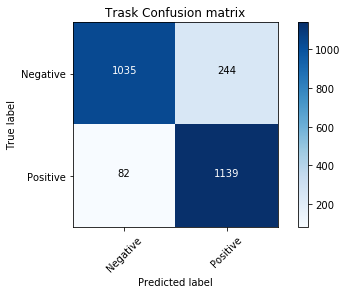

In [18]:
y_true_trask = testY
y_pred_trask = traskModel.test(testReviews, testLabels)

print('\n\nTrask Testing Accuracy: 86.9%') # from above

plot_confusion_matrix(confusion_matrix(y_true_trask, y_pred_trask), classes=['Negative', 'Positive'], title='Trask Confusion matrix')

## Summary

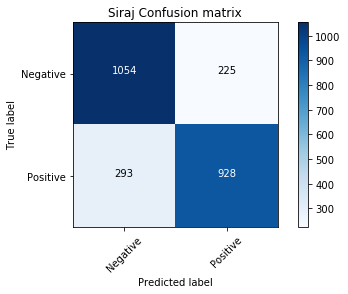

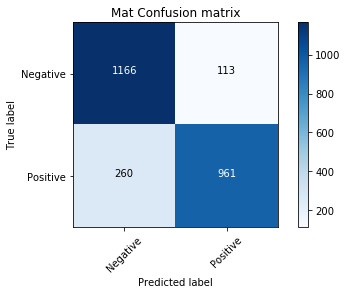

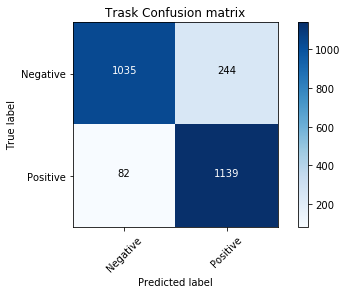

In [21]:
plot_confusion_matrix(confusion_matrix(y_true_siraj, y_pred_siraj), classes=['Negative', 'Positive'], title='Siraj Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_true_mat, y_pred_mat), classes=['Negative', 'Positive'], title='Mat Confusion matrix')
plot_confusion_matrix(confusion_matrix(y_true_trask, y_pred_trask), classes=['Negative', 'Positive'], title='Trask Confusion matrix')

## Try out your own text!

In [24]:
def predictAll(text):
    text = text.replace('.', ' ').replace(',', ' ')
    index_list = np.asarray(phrase_to_index_list(text.lower()))

    predictSiraj = sirajModel.predict(pad_sequences(index_list[None,:], maxlen=100, value=0.))
    
    print("'", text, "'")

    print('Siraj: Negative: {:.3f} Positive: {:.3f}'.format(predictSiraj[0][0], predictSiraj[0][1]))

    predictMat = matModel.predict(index_sequence_to_vector(index_list)[None,:])
    print('Mat  : Negative: {:.3f} Positive: {:.3f}'.format(predictMat[0][0], predictMat[0][1]))
    
    predictTrask = traskModel.run(text, detailed=True)
    
    print('Trask: Positive/Negative:        {:.3f}'.format(predictTrask[0]))
    
    print()
    
predictAll("This movie was so bad . It was awful and the worst")
predictAll("This movie was so bad .")
predictAll("This movie was bad in the begining, but it was excellent overall .")
predictAll("This movie was good in the begining, but it was awful overall. .")
predictAll("Fantastic Four was a piece of shit.")
predictAll("Fantastic Four started catching my eye in the casting stage. Seemingly not giving a damn about the source material, it was refreshing to see those kind of balls especially from Marvel. While I welcome Michael B. Jordan as The Human Torch, I wish I could say the same thing about the rest of the film. Fantastic Four is merely a reboot that loses its steam after the first act. Coming in at just over an hour and a half, the film is a rushed piece of reject summer movie drab. The characters are paper thin and about 10 years too young for their respective roles. The visual effects are far from stunning, especially The Thing, whose transformation into the ghastly beast is something closer to a PS2 game than an actual film with a $100 million price tag. Miles Teller proves here that his performance in Whiplash is truly a fluke. As Mr. Fantastic, he struggles to sound like he knows what he is talking about. Perhaps a little more rehearsal time and a little less focus on that cheap looking silver streak in his hair could have benefited him. Kate Mara as Susan Storm is about as idiotic as it can get. Mara is a great actress, there's no other way about it but Kate Mara as Susan Storm is terrible and borderline embarrassing. The biggest shock here in this film is where all the controversy started...Michael B. Jordan as The Human Torch. Jordan's ability to be a badass likable gear head is insanely good. He's the best part of this film by far. If there is anyone that could single handedly carry this film on their back, it is him. The film overall is too dark for Fantastic Four and too shallow for Marvel which leaves it drifting somewhere between ridiculous and not necessary...and at times, both. If there's any movie to see this summer, I can assure you, Fantastic Four is NOT it.")

' This movie was so bad   It was awful and the worst '
Siraj: Negative: 0.936 Positive: 0.064
Mat  : Negative: 0.998 Positive: 0.002
Trask: Positive/Negative:        0.025

' This movie was so bad   '
Siraj: Negative: 0.870 Positive: 0.130
Mat  : Negative: 0.884 Positive: 0.116
Trask: Positive/Negative:        0.330

' This movie was bad in the begining  but it was excellent overall   '
Siraj: Negative: 0.265 Positive: 0.735
Mat  : Negative: 0.394 Positive: 0.606
Trask: Positive/Negative:        0.648

' This movie was good in the begining  but it was awful overall    '
Siraj: Negative: 0.878 Positive: 0.122
Mat  : Negative: 0.882 Positive: 0.118
Trask: Positive/Negative:        0.255

' Fantastic Four was a piece of shit  '
Siraj: Negative: 0.321 Positive: 0.679
Mat  : Negative: 0.615 Positive: 0.385
Trask: Positive/Negative:        0.446

' Fantastic Four started catching my eye in the casting stage  Seemingly not giving a damn about the source material  it was refreshing to see thos